Loading dosage sensitive TF data...
# targets1: 122
# targets2: 368
# splits: 5
Loading training dataset...
Extracting features for classification...
Creating gene co-expression features...


100%|██████████| 10000/10000 [56:14<00:00,  2.96it/s] 


Feature matrix shape: (490, 4)
Labels distribution: [122 368]
Starting 5-fold cross-validation...

Fold 1/5

Random Forest Results:
Accuracy: 0.7551
Precision (Macro): 0.6710
Precision (Weighted): 0.7431
F1 (Macro): 0.6591
F1 (Weighted): 0.7477

Logistic Regression Results:
Accuracy: 0.7449
Precision (Macro): 0.6538
Precision (Weighted): 0.7292
F1 (Macro): 0.6394
F1 (Weighted): 0.7349

Fold 2/5

Random Forest Results:
Accuracy: 0.8367
Precision (Macro): 0.7922
Precision (Weighted): 0.8304
F1 (Macro): 0.7728
F1 (Weighted): 0.8318

Logistic Regression Results:
Accuracy: 0.7959
Precision (Macro): 0.7329
Precision (Weighted): 0.8016
F1 (Macro): 0.7382
F1 (Weighted): 0.7984

Fold 3/5

Random Forest Results:
Accuracy: 0.7755
Precision (Macro): 0.6938
Precision (Weighted): 0.7695
F1 (Macro): 0.6875
F1 (Weighted): 0.7721

Logistic Regression Results:
Accuracy: 0.7551
Precision (Macro): 0.6645
Precision (Weighted): 0.7484
F1 (Macro): 0.6591
F1 (Weighted): 0.7514

Fold 4/5

Random Forest Results

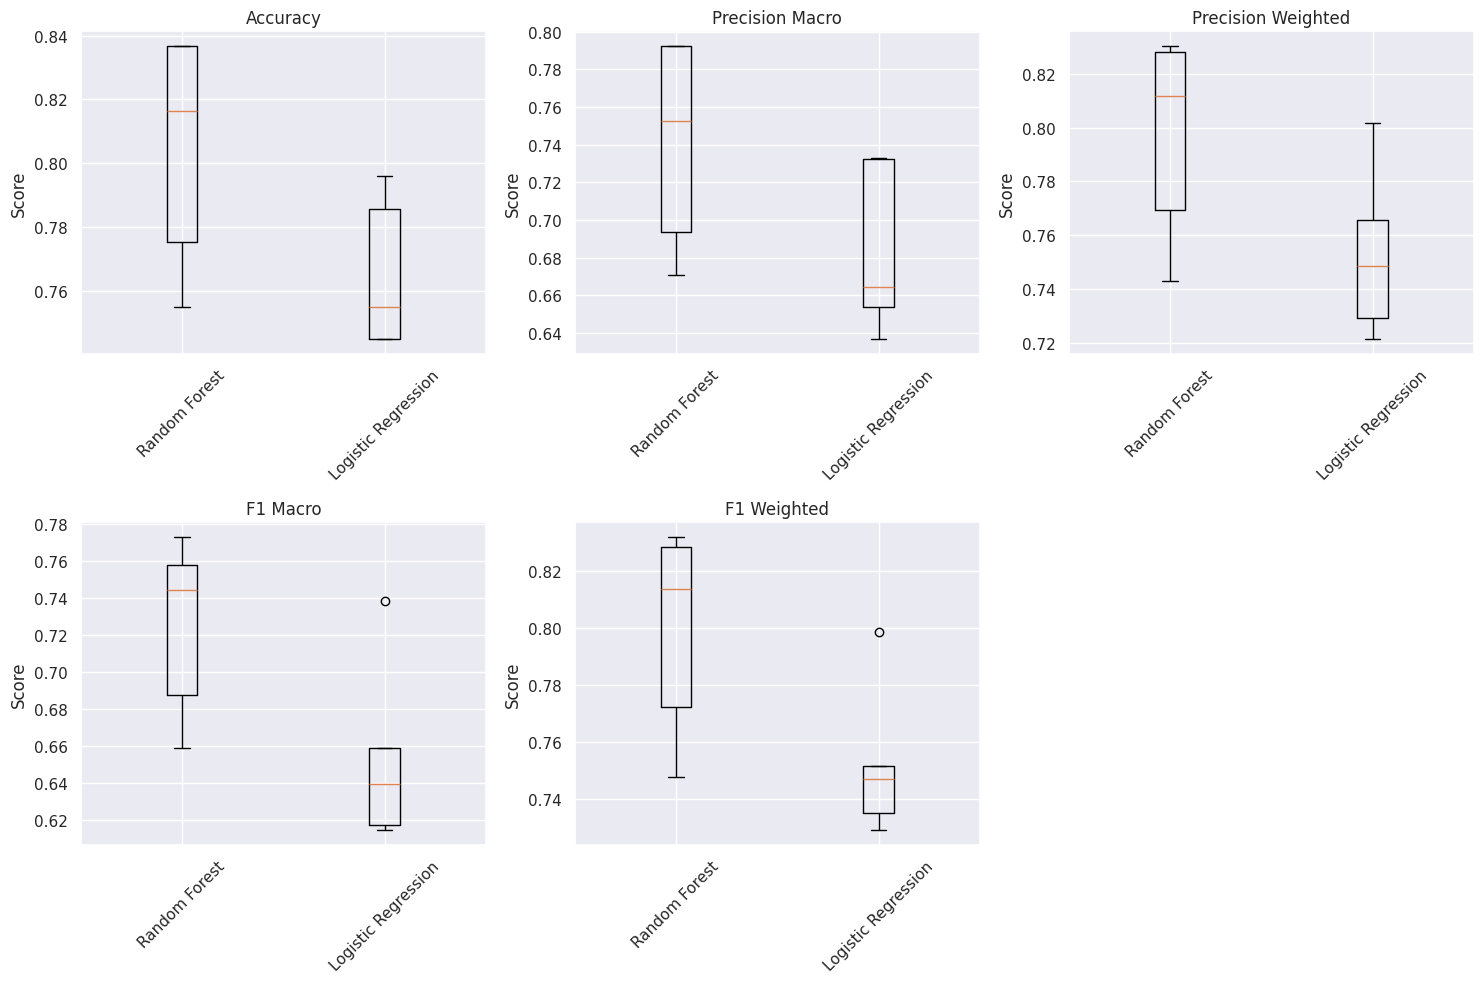


Results saved to: Downstream/ml_classification_results_250831/


In [ ]:
import os
import sys
import datetime
import numpy as np
import pandas as pd
from datasets import load_from_disk
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, classification_report, confusion_matrix)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load gene information
gene_info = pd.read_csv("example_input_files/gene_info_table.csv", index_col=0)

# Create dictionaries for gene mappings
gene_id_type_dict = dict(zip(gene_info["ensembl_id"], gene_info["gene_type"]))
gene_name_id_dict = dict(zip(gene_info["gene_name"], gene_info["ensembl_id"]))
gene_id_name_dict = {v: k for k, v in gene_name_id_dict.items()}

# Load token dictionary (assuming it exists from the original script)
from geneformer.pretrainer import token_dictionary

def prep_inputs(genegroup1, genegroup2, id_type):
    """Prepare gene targets and labels for classification"""
    if id_type == "gene_name":
        targets1 = [gene_name_id_dict[gene] for gene in genegroup1 if gene_name_id_dict.get(gene) in token_dictionary]
        targets2 = [gene_name_id_dict[gene] for gene in genegroup2 if gene_name_id_dict.get(gene) in token_dictionary]
    elif id_type == "ensembl_id":
        targets1 = [gene for gene in genegroup1 if gene in token_dictionary]
        targets2 = [gene for gene in genegroup2 if gene in token_dictionary]
    
    targets1_id = [token_dictionary[gene] for gene in targets1]
    targets2_id = [token_dictionary[gene] for gene in targets2]
    
    targets = np.array(targets1_id + targets2_id)
    labels = np.array([0]*len(targets1_id) + [1]*len(targets2_id))
    nsplits = min(5, min(len(targets1_id), len(targets2_id))-1)
    assert nsplits > 2
    print(f"# targets1: {len(targets1_id)}\n# targets2: {len(targets2_id)}\n# splits: {nsplits}")
    return targets, labels, nsplits

def extract_features_from_cells(dataset, target_genes):
    """Extract features from cell data for traditional ML models"""
    print("Extracting features from cell data...")
    
    # Convert target genes to set for faster lookup
    target_gene_set = set(target_genes)
    
    features = []
    cell_labels = []
    
    for i, sample in enumerate(tqdm(dataset)):
        input_ids = sample['input_ids']
        
        # Check if any target genes are in this cell
        genes_in_cell = set(input_ids) & target_gene_set
        if not genes_in_cell:
            continue
            
        # Create feature vector based on gene expression patterns
        feature_vector = create_feature_vector(input_ids, target_genes)
        features.append(feature_vector)
        
        # Create labels for each target gene present in this cell
        for gene_id in genes_in_cell:
            if gene_id in target_genes:
                cell_labels.append(gene_id)
    
    return np.array(features), cell_labels

def create_feature_vector(input_ids, target_genes):
    """Create feature vector from gene expression data"""
    # Simple features: gene presence/absence and position-based features
    feature_vector = []
    
    # Feature 1: Length of gene sequence
    feature_vector.append(len(input_ids))
    
    # Feature 2-3: First and last gene IDs (normalized)
    if len(input_ids) > 0:
        feature_vector.extend([input_ids[0], input_ids[-1]])
    else:
        feature_vector.extend([0, 0])
    
    # Feature 4: Number of unique genes
    feature_vector.append(len(set(input_ids)))
    
    # Feature 5: Average gene ID (as proxy for gene expression level)
    feature_vector.append(np.mean(input_ids) if input_ids else 0)
    
    # Feature 6-10: Statistical features
    if input_ids:
        feature_vector.extend([
            np.std(input_ids),
            np.min(input_ids),
            np.max(input_ids),
            np.median(input_ids),
            len([x for x in input_ids if x in target_genes])  # Number of target genes
        ])
    else:
        feature_vector.extend([0, 0, 0, 0, 0])
    
    return feature_vector

def create_gene_coexpression_features(dataset, target_genes, max_samples=10000):
    """Create gene co-expression features for target genes"""
    print("Creating gene co-expression features...")
    
    # Sample dataset if too large
    if len(dataset) > max_samples:
        indices = np.random.choice(len(dataset), max_samples, replace=False)
        sampled_dataset = dataset.select(indices.tolist())
    else:
        sampled_dataset = dataset
    
    # Create gene co-occurrence matrix
    gene_cooccurrence = {}
    target_gene_features = {}
    
    for gene in target_genes:
        gene_cooccurrence[gene] = []
        target_gene_features[gene] = {
            'avg_position': [],
            'expression_frequency': 0,
            'coexpressed_genes': set()
        }
    
    total_cells = len(sampled_dataset)
    
    for sample in tqdm(sampled_dataset):
        input_ids = sample['input_ids']
        
        for gene in target_genes:
            if gene in input_ids:
                target_gene_features[gene]['expression_frequency'] += 1
                positions = [i for i, x in enumerate(input_ids) if x == gene]
                target_gene_features[gene]['avg_position'].extend(positions)
                target_gene_features[gene]['coexpressed_genes'].update(input_ids)
    
    # Create feature matrix for target genes
    feature_matrix = []
    gene_labels = []
    
    for gene in target_genes:
        features = [
            target_gene_features[gene]['expression_frequency'] / total_cells,  # Expression frequency
            np.mean(target_gene_features[gene]['avg_position']) if target_gene_features[gene]['avg_position'] else 0,  # Avg position
            len(target_gene_features[gene]['coexpressed_genes']),  # Number of coexpressed genes
            gene,  # Gene ID itself as a feature
        ]
        feature_matrix.append(features)
        gene_labels.append(gene)
    
    return np.array(feature_matrix), gene_labels

def evaluate_classifier(classifier, X_train, X_test, y_train, y_test, classifier_name):
    """Evaluate classifier and return metrics"""
    # Fit the classifier
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = {
        'classifier': classifier_name,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    
    print(f"\n{classifier_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"F1 (Macro): {f1_macro:.4f}")
    print(f"F1 (Weighted): {f1_weighted:.4f}")
    
    return results, classifier

def cross_validate_classifiers(X, y, target_genes, labels, nsplits=5):
    """Perform cross-validation for all classifiers"""
    
    # Initialize classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        # 'SVM': SVC(random_state=42, probability=True)
    }
    
    # Initialize results storage
    all_results = []
    
    # Set up cross-validation
    skf = StratifiedKFold(n_splits=nsplits, random_state=42, shuffle=True)
    
    print(f"Starting {nsplits}-fold cross-validation...")
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, labels)):
        print(f"\nFold {fold + 1}/{nsplits}")
        
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = np.array(labels)[train_idx], np.array(labels)[test_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        fold_results = []
        
        # Evaluate each classifier
        for clf_name, classifier in classifiers.items():
            try:
                if clf_name == 'SVM':
                    # Use scaled features for SVM
                    results, trained_clf = evaluate_classifier(
                        classifier, X_train_scaled, X_test_scaled, y_train, y_test, clf_name
                    )
                else:
                    # Use original features for tree-based methods
                    results, trained_clf = evaluate_classifier(
                        classifier, X_train, X_test, y_train, y_test, clf_name
                    )
                
                results['fold'] = fold + 1
                fold_results.append(results)
                
            except Exception as e:
                print(f"Error with {clf_name}: {str(e)}")
                continue
        
        all_results.extend(fold_results)
    
    return all_results

def plot_results(results_df):
    """Plot comparison of classifier performance"""
    metrics = ['accuracy', 'precision_macro', 'precision_weighted', 'f1_macro', 'f1_weighted']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Create box plot
        data_to_plot = []
        labels_to_plot = []
        
        for classifier in results_df['classifier'].unique():
            classifier_data = results_df[results_df['classifier'] == classifier][metric]
            data_to_plot.append(classifier_data)
            labels_to_plot.append(classifier)
        
        ax.boxplot(data_to_plot, labels=labels_to_plot)
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel('Score')
        ax.tick_params(axis='x', rotation=45)
    
    # Remove empty subplot
    axes[-1].remove()
    
    plt.tight_layout()
    plt.show()

def main():
    # Load dosage sensitive TF data
    print("Loading dosage sensitive TF data...")
    dosage_tfs = pd.read_csv("example_input_files/gene_classification/dosage_sensitive_tfs/dosage_sens_tf_labels.csv", header=0)
    sensitive = dosage_tfs["dosage_sensitive"].dropna()
    insensitive = dosage_tfs["dosage_insensitive"].dropna()
    targets, labels, nsplits = prep_inputs(sensitive, insensitive, "ensembl_id")
    
    # Load training dataset
    print("Loading training dataset...")
    train_dataset = load_from_disk("Genecorpus-30M/genecorpus_30M_2048.dataset")
    
    # Subsample dataset for efficiency
    shuffled_train_dataset = train_dataset.shuffle(seed=42)
    subsampled_train_dataset = shuffled_train_dataset.select([i for i in range(50_000)])
    
    # Extract features
    print("Extracting features for classification...")
    X, gene_labels = create_gene_coexpression_features(subsampled_train_dataset, targets, max_samples=10000)
    
    # Create binary labels (0 for sensitive, 1 for insensitive)
    y = []
    for gene_id in gene_labels:
        if gene_id in [token_dictionary.get(gene, -1) for gene in sensitive if token_dictionary.get(gene) is not None]:
            y.append(0)  # Sensitive
        else:
            y.append(1)  # Insensitive
    
    y = np.array(y)
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Labels distribution: {np.bincount(y)}")
    
    # Perform cross-validation
    all_results = cross_validate_classifiers(X, y, targets, y, nsplits=nsplits)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Calculate and display summary statistics
    print("\n" + "="*60)
    print("CROSS-VALIDATION SUMMARY")
    print("="*60)
    
    summary_stats = results_df.groupby('classifier').agg({
        'accuracy': ['mean', 'std'],
        'precision_macro': ['mean', 'std'],
        'precision_weighted': ['mean', 'std'],
        'f1_macro': ['mean', 'std'],
        'f1_weighted': ['mean', 'std']
    }).round(4)
    
    print(summary_stats)
    
    # Plot results
    plot_results(results_df)
    
    # Save results
    current_date = datetime.datetime.now()
    datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
    output_dir = f"Downstream/ml_classification_results_{datestamp}/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save detailed results
    results_df.to_csv(os.path.join(output_dir, "detailed_results.csv"), index=False)
    summary_stats.to_csv(os.path.join(output_dir, "summary_statistics.csv"))
    
    # Save feature matrix and labels for future use
    np.save(os.path.join(output_dir, "feature_matrix.npy"), X)
    np.save(os.path.join(output_dir, "labels.npy"), y)
    
    print(f"\nResults saved to: {output_dir}")
    
    return results_df, summary_stats

if __name__ == "__main__":
    # Import sys for path manipulation
    import sys
    
    # Run main function
    results_df, summary_stats = main()